In [1]:
# Importing required Module and Libraries
from PIL import Image
from pylab import *
get_ipython().run_line_magic('matplotlib', 'inline')
import cv2
import numpy as num, math
import numpy as np
from math import pi, sqrt, exp
import matplotlib.pyplot as plt

In [2]:
# Defining the image paths and sigma values
I = ["198004.jpg", "135069.jpg", "187003.jpg"]
sigma_values = [1.0, 1.5, 3.0]

In [3]:
# Method to compute the Gaussian function
def gaussian(x, sigma):
    return (1 / (np.sqrt(2 * np.pi) * sigma)) * np.exp(-x**2 / (2 * sigma**2))

# Method to compute the derivative of the Gaussian function
def gaussian_derivative(x, sigma):
    return (-x / sigma**2) * gaussian(x, sigma)

# Method to get the Gausian Kernels and it's derivatives
# Define the kernel size based on sigma
def get_gaussian_kernels(sigma):
    ksize = int(6*sigma + 1)
    ksize = ksize + 1 if ksize % 2 == 0 else ksize
    
    # Create an array representing the distance from the center
    x = np.arange(-ksize // 2 + 1., ksize // 2 + 1.)
    
    # Calculate the Gaussian and its derivative
    g = gaussian(x, sigma)
    gd = gaussian_derivative(x, sigma)
    
    return g.reshape(-1, 1), gd.reshape(-1, 1)

In [4]:
# Method to implement Canny edge detection algorithm
def canny_edge_detection(image, sigma):
    # Get Gaussian and its derivative
    g, gd = get_gaussian_kernels(sigma)
    
    # 1. Gaussian smoothing
    blurred_image = cv2.GaussianBlur(image, (0, 0), sigma)
    
    # 2. Compute gradient in x and y directions using convolution with the derivative of Gaussian
    Ix = cv2.Sobel(blurred_image, cv2.CV_64F, 1, 0, ksize=5)
    Iy = cv2.Sobel(blurred_image, cv2.CV_64F, 0, 1, ksize=5)
        
    # 3. Compute magnitude and angle of the gradient
    magnitude = np.sqrt(Ix**2 + Iy**2)
    angle = np.arctan2(Iy, Ix)
    
    # 4. Non-maximum suppression
    nms = np.zeros_like(magnitude)
    for i in range(1, image.shape[0]-1):
        for j in range(1, image.shape[1]-1):
            if (0 <= angle[i, j] < np.pi/4) or (7*np.pi/4 <= angle[i, j] <= 2*np.pi):
                if (magnitude[i, j] >= magnitude[i, j-1]) and (magnitude[i, j] >= magnitude[i, j+1]):
                    nms[i, j] = magnitude[i, j]
            elif np.pi/4 <= angle[i, j] < 3*np.pi/4:
                if (magnitude[i, j] >= magnitude[i-1, j]) and (magnitude[i, j] >= magnitude[i+1, j]):
                    nms[i, j] = magnitude[i, j]
            elif 3*np.pi/4 <= angle[i, j] < 5*np.pi/4:
                if (magnitude[i, j] >= magnitude[i, j-1]) and (magnitude[i, j] >= magnitude[i, j+1]):
                    nms[i, j] = magnitude[i, j]
            else:
                if (magnitude[i, j] >= magnitude[i-1, j]) and (magnitude[i, j] >= magnitude[i+1, j]):
                    nms[i, j] = magnitude[i, j]

    # 5. Hysteresis thresholding
    high_threshold = np.percentile(nms, 90)
    low_threshold = high_threshold * 0.5
    edges = cv2.Canny(image, low_threshold, high_threshold)
    
    return edges

In [5]:
# Method to process the image through several edge detection stages
def process_image_for_display(image, sigma):
    
    results = []
    ksize = int(6*sigma + 1)
    
    # Ensure the kernel size is odd
    ksize = ksize + 1 if ksize % 2 == 0 else ksize
    
    # (a) X component of the convolution with a Gaussian
    Gx = cv2.getGaussianKernel(ksize=ksize, sigma=sigma)
    I_gx = cv2.filter2D(image, -1, Gx)
    results.append(I_gx)
    
    # (b) Y component of the convolution with a Gaussian
    Gy = Gx.T
    I_gy = cv2.filter2D(image, -1, Gy)
    results.append(I_gy)
    
    # (c) X component of the image convolved with the derivative of a Gaussian
    Ix = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=5)
    results.append(Ix)
    
    # (d) Y component of the image convolved with the derivative of a Gaussian
    Iy = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=5)
    results.append(Iy)
    
    # (e) Resulting magnitude image
    magnitude = np.hypot(Ix, Iy)
    results.append(magnitude)
    
    # (f) Canny-edge image after non-maximum suppression
    edges = canny_edge_detection(image, sigma)
    results.append(edges)
    
    # (g) Image after hysteresis thresholding
    high_threshold = np.percentile(results[4], 90)
    low_threshold = high_threshold * 0.5
    hysteresis_image = apply_hysteresis_thresholding(image, results[4], low_threshold, high_threshold)
    results.append(hysteresis_image)
    
    return results

In [6]:
# Method to perform hysteresis thresholding on an edge magnitude image
def apply_hysteresis_thresholding(image, magnitude, low_threshold, high_threshold):
    # Initializing the output image with zeros
    output = np.zeros_like(magnitude)
    
    # Identifying strong and weak pixels
    strong_i, strong_j = np.where(magnitude >= high_threshold)
    weak_i, weak_j = np.where((magnitude <= high_threshold) & (magnitude >= low_threshold))
    
    # Setting the intensity of the strong pixels to the maximum value (255)
    output[strong_i, strong_j] = 255
    
    # Traverse the image
    for i in range(1, image.shape[0] - 1):
        for j in range(1, image.shape[1] - 1):
            if magnitude[i, j] == 255:
                # If the pixel has a neighboring strong pixel, then set its intensity to the maximum value
                if 255 in magnitude[i-1:i+2, j-1:j+2]:
                    output[i, j] = 255
                    
    return output

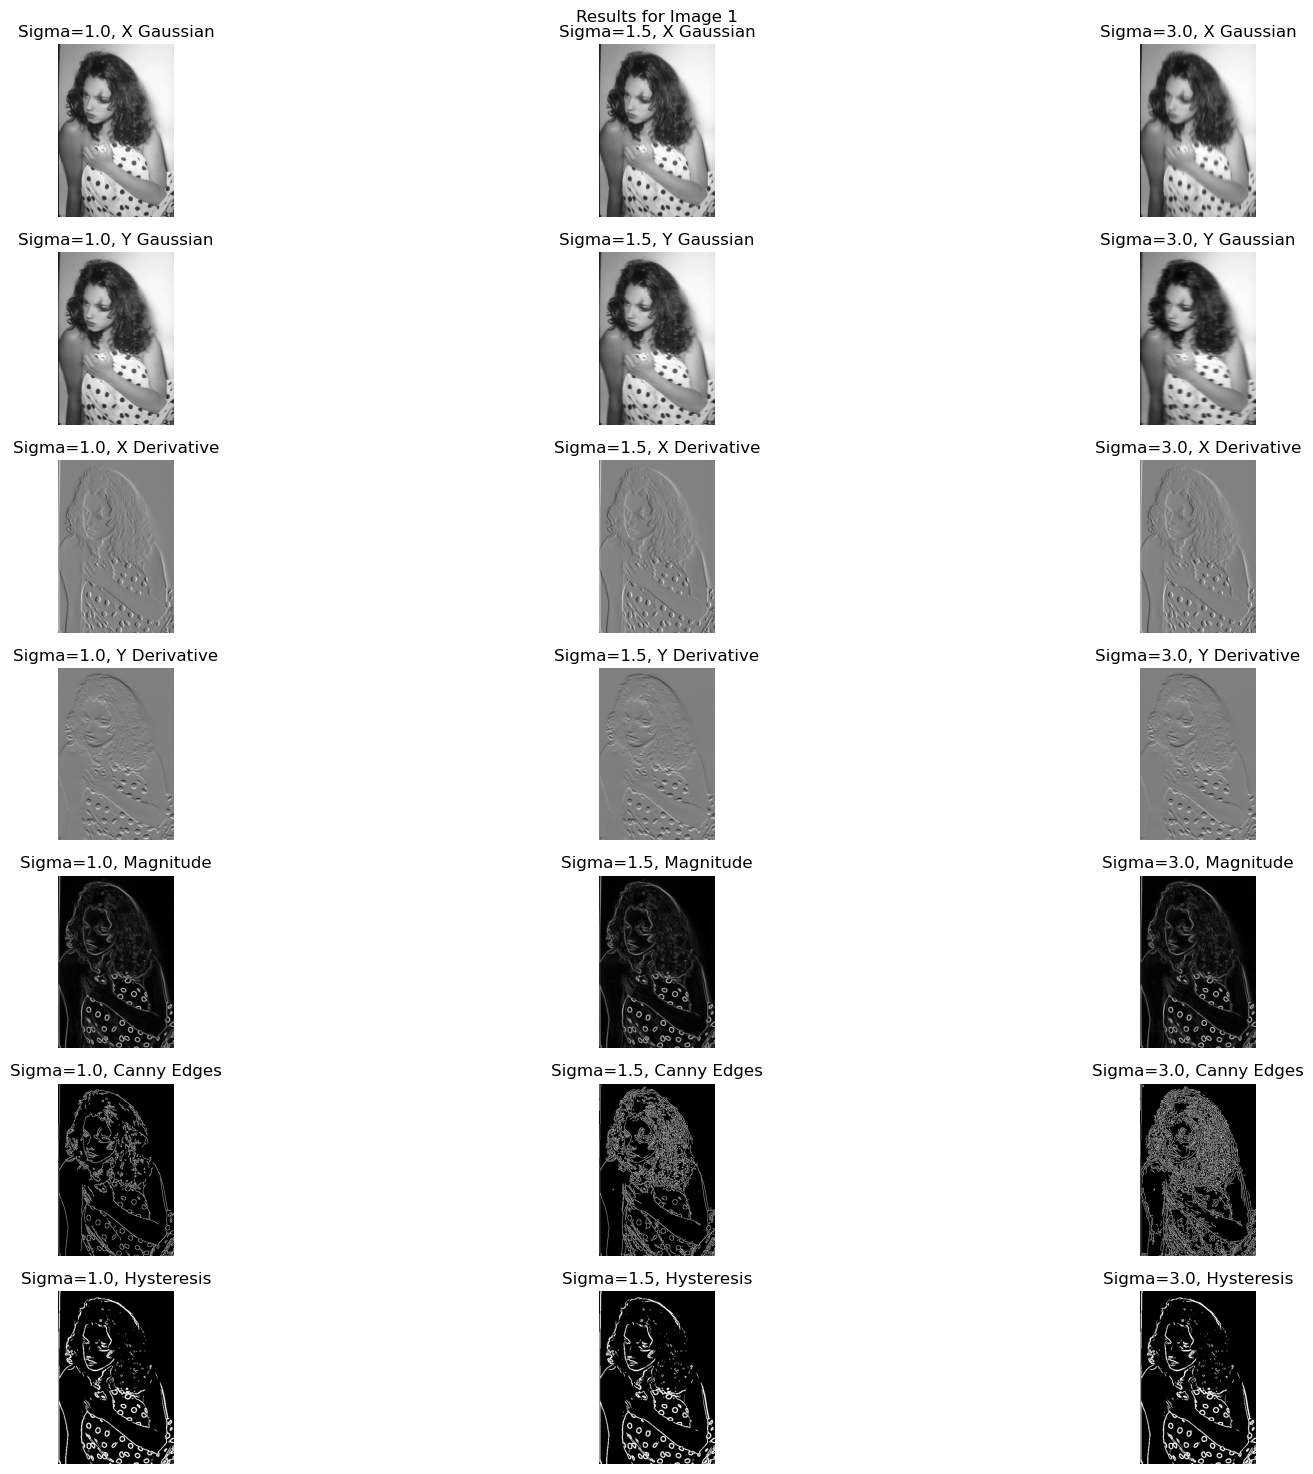

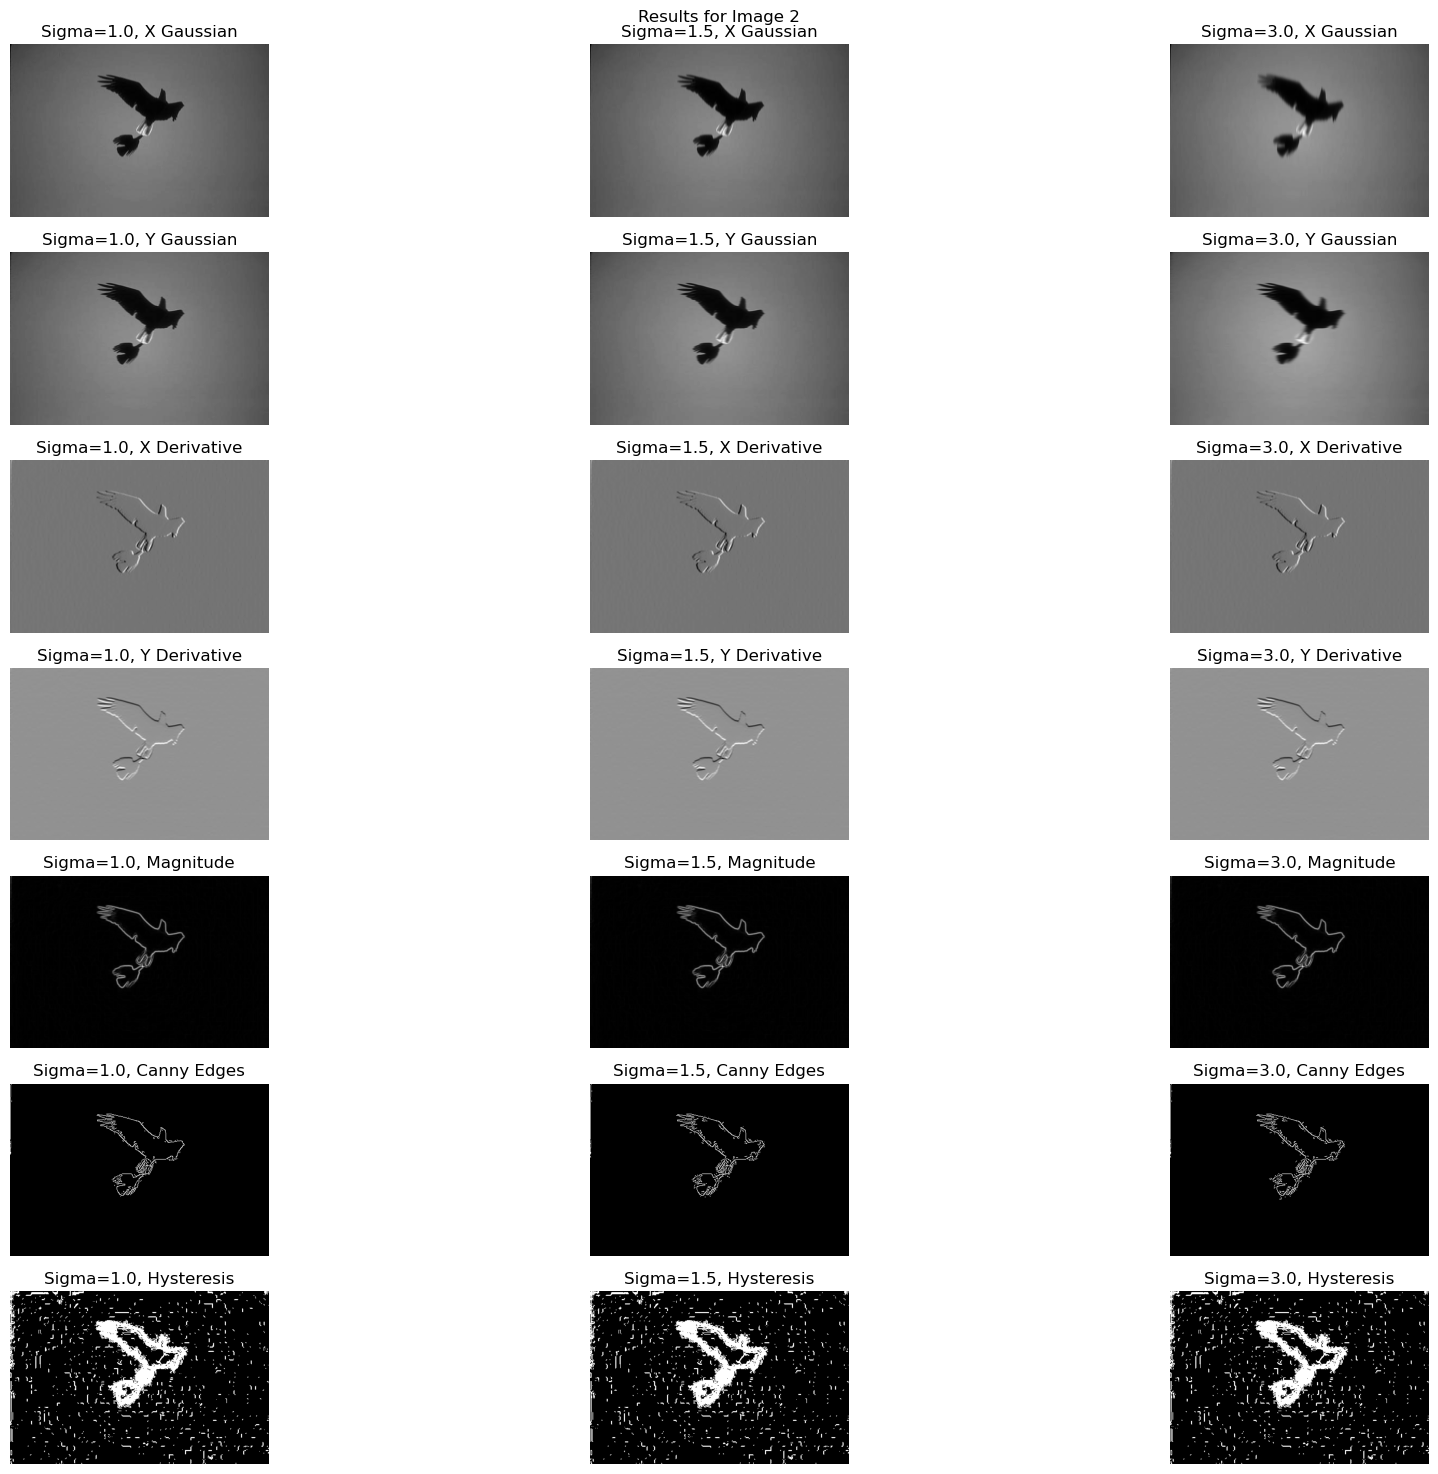

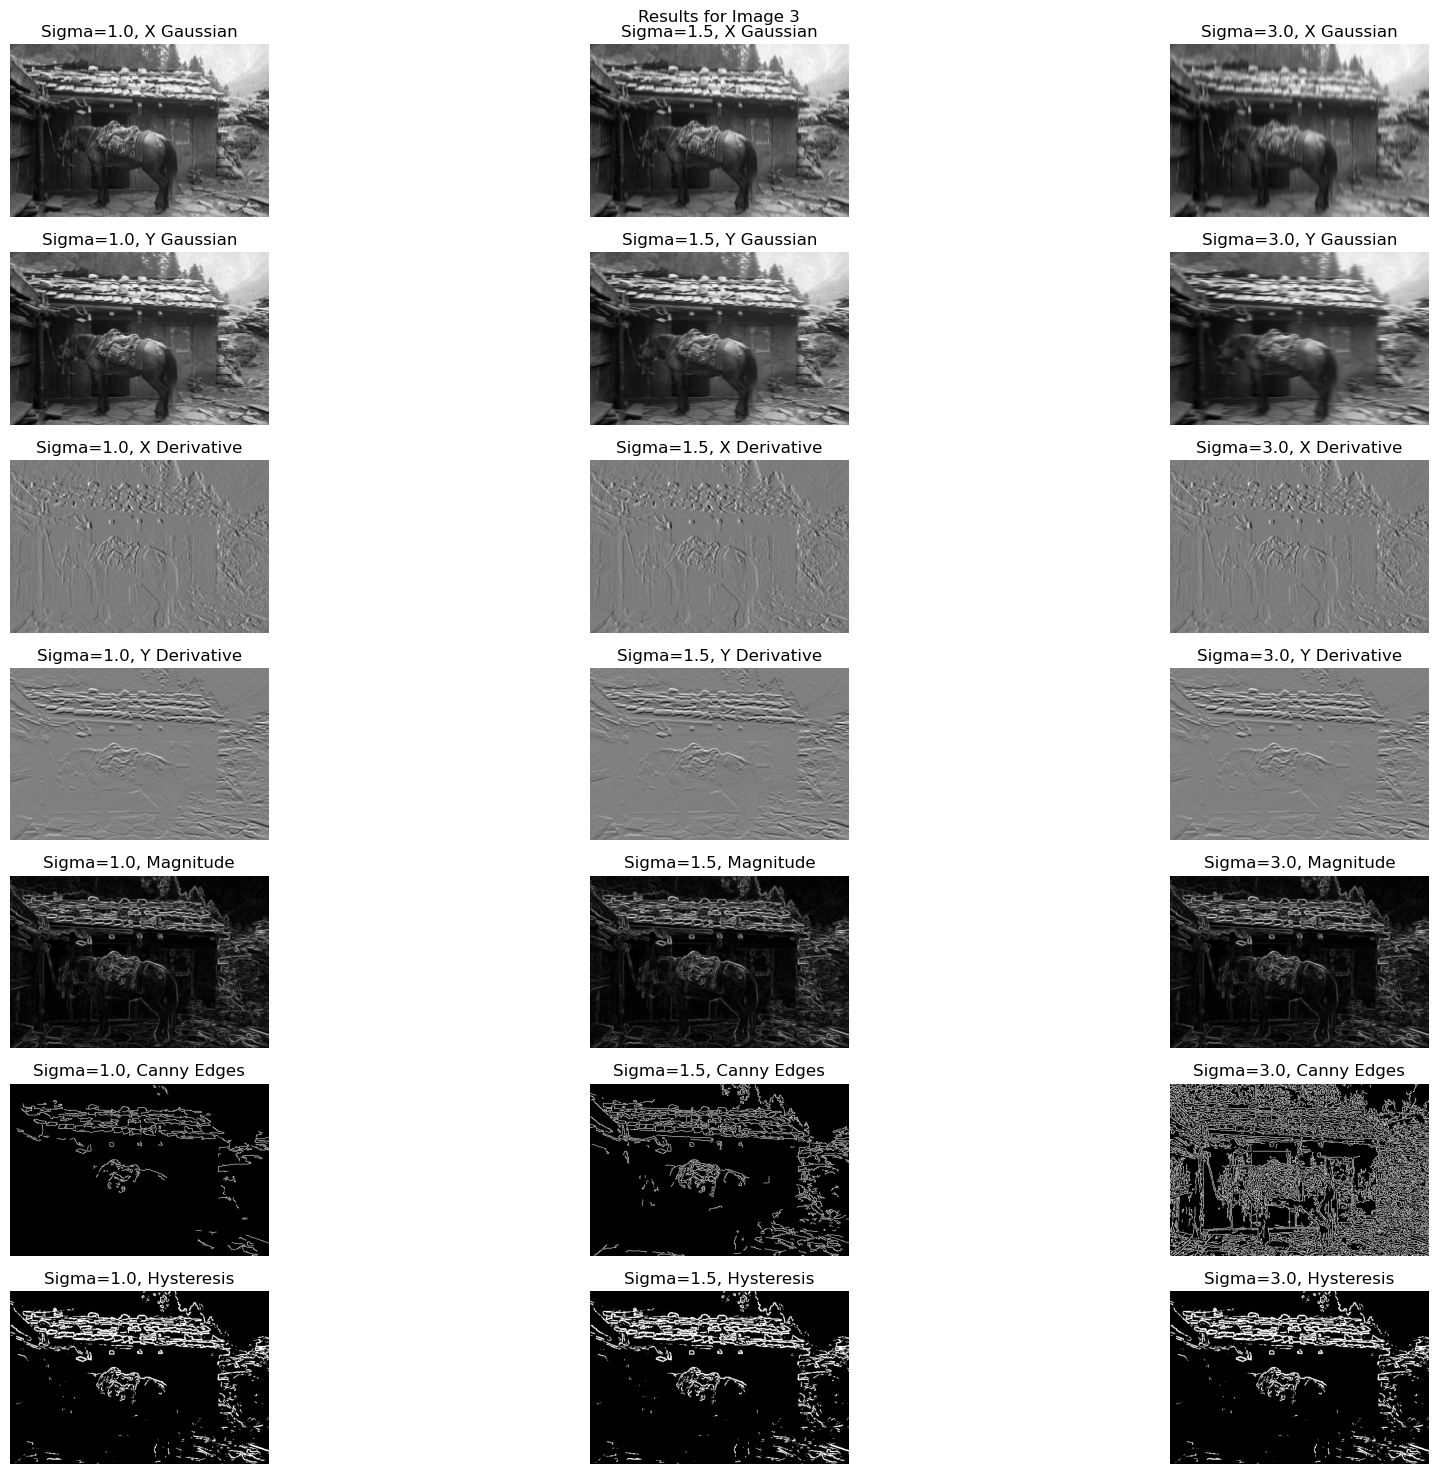

In [7]:
# Displaying the results for each image separately, grouped by sigma value

for idx, img_path in enumerate(I):
    image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    
    plt.figure(figsize=(20, 15))
    for s_idx, sigma in enumerate(sigma_values):
        results = process_image_for_display(image, sigma)
        
        for r_idx, result in enumerate(results):
            plt.subplot(len(results), len(sigma_values), r_idx * len(sigma_values) + s_idx + 1)
            plt.imshow(result, cmap='gray')
            
            # Title for each subplot
            titles = ['X Gaussian', 'Y Gaussian', 'X Derivative', 'Y Derivative', 'Magnitude', 'Canny Edges', 'Hysteresis']
            plt.title(f'Sigma={sigma}, {titles[r_idx]}')
            plt.axis('off')
    
    plt.suptitle(f'Results for Image {idx+1}')
    plt.tight_layout()
    plt.show()


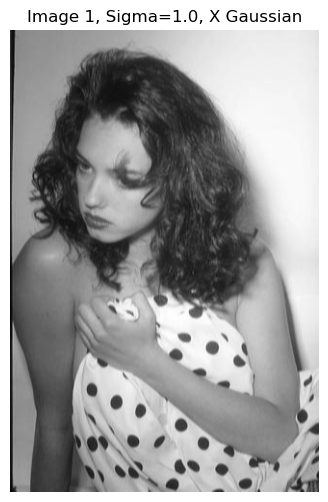

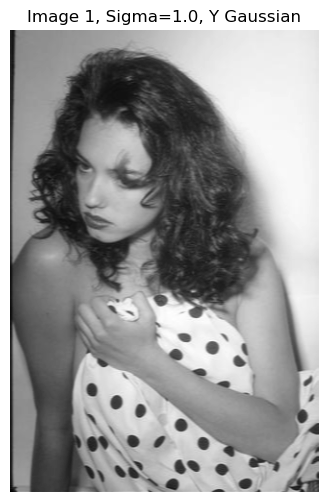

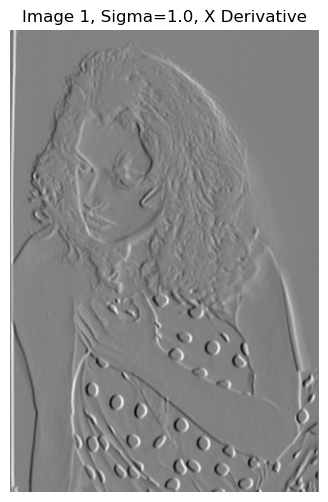

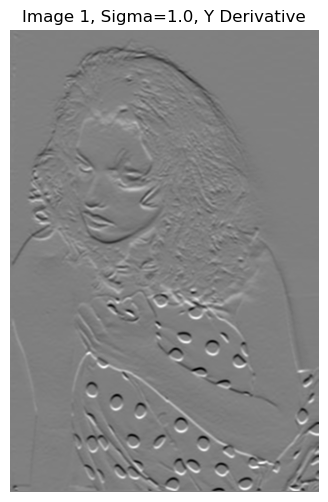

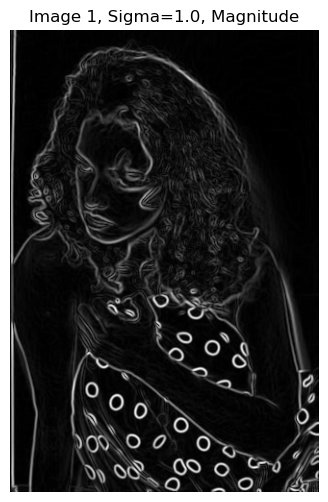

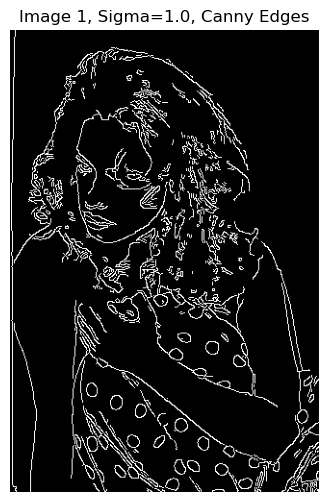

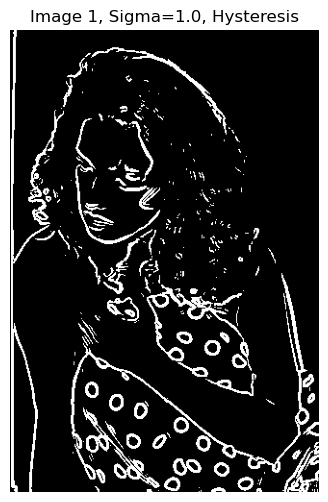

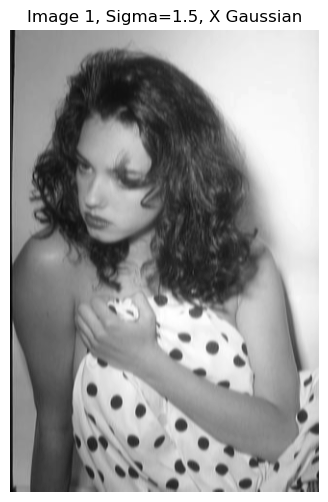

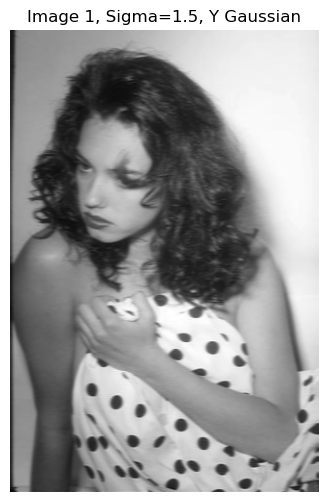

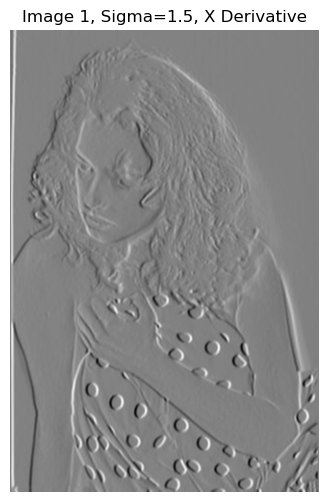

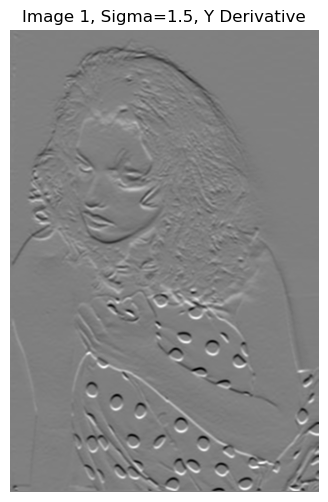

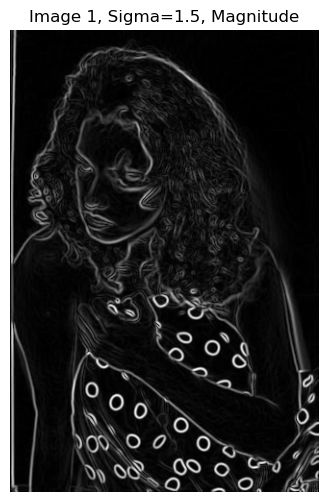

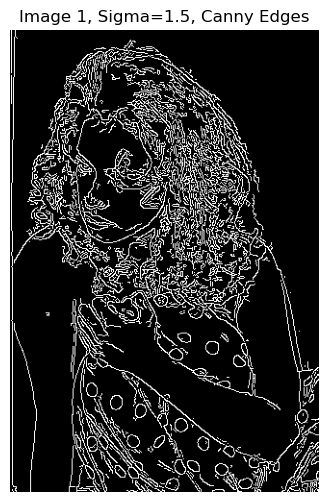

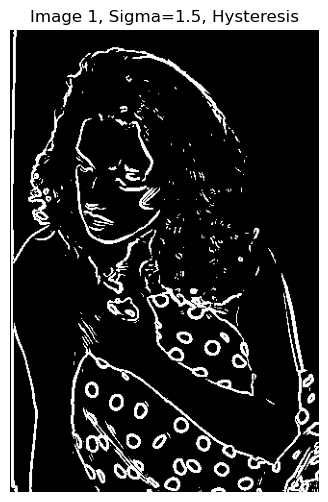

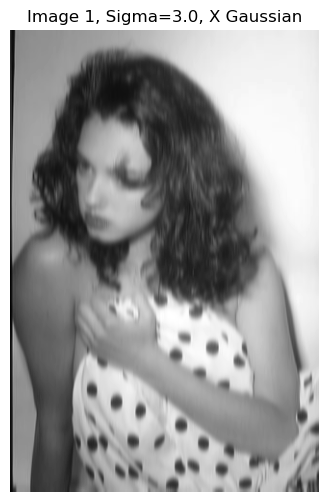

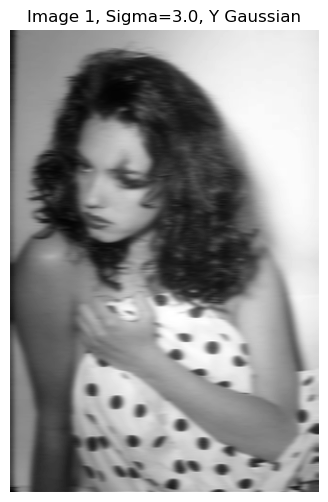

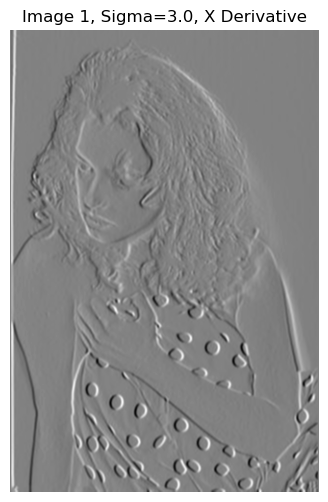

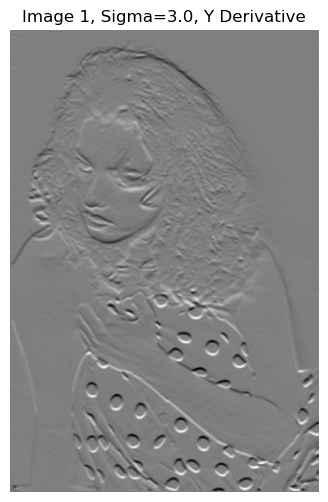

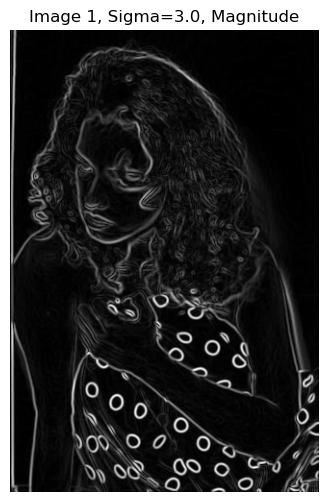

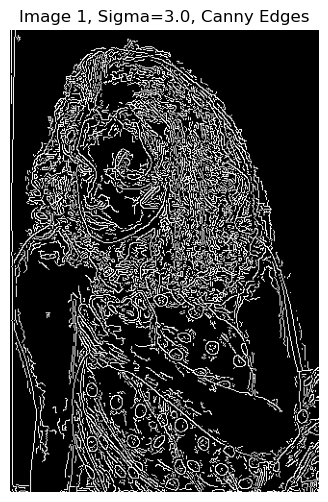

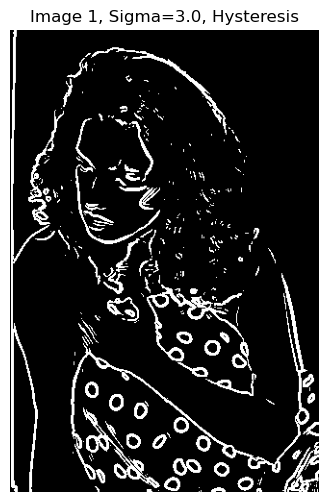

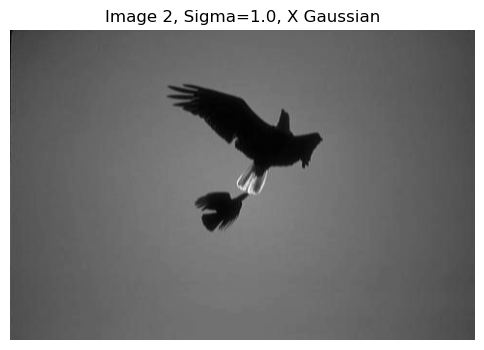

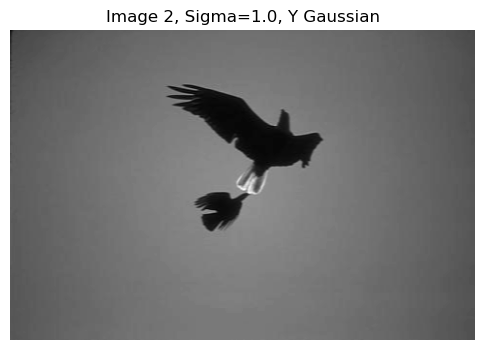

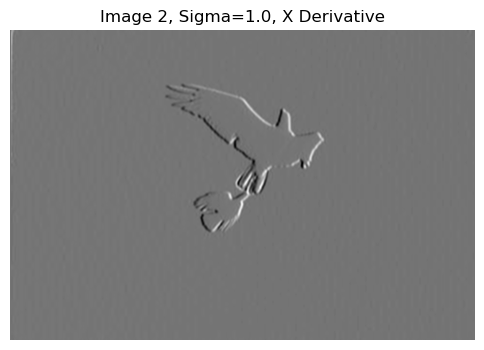

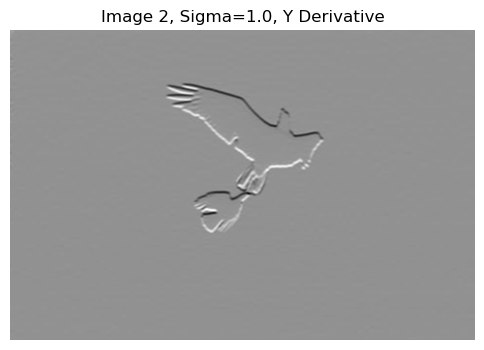

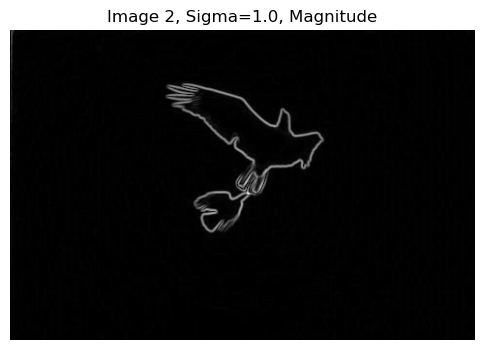

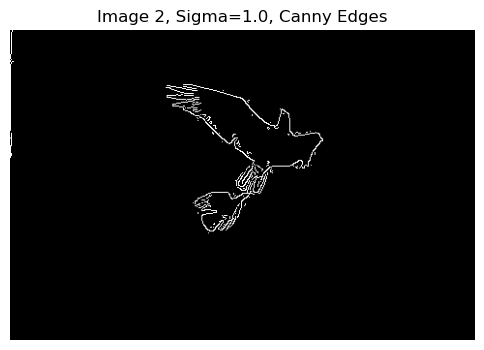

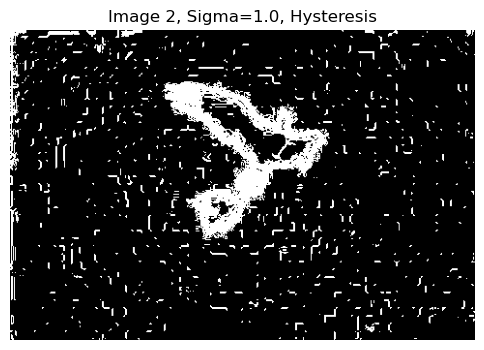

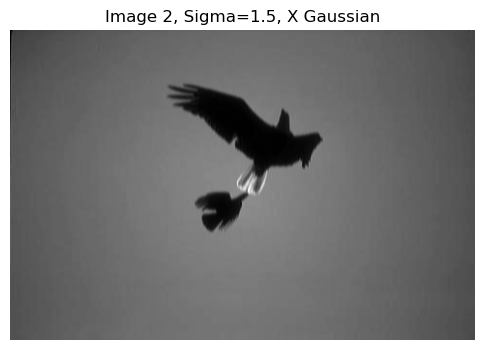

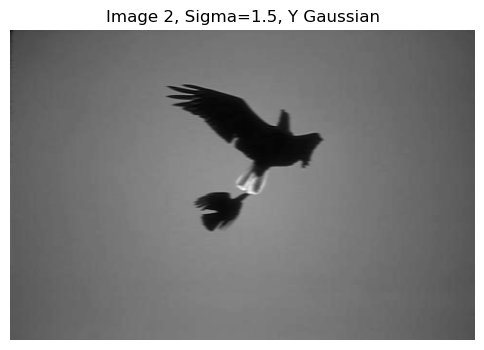

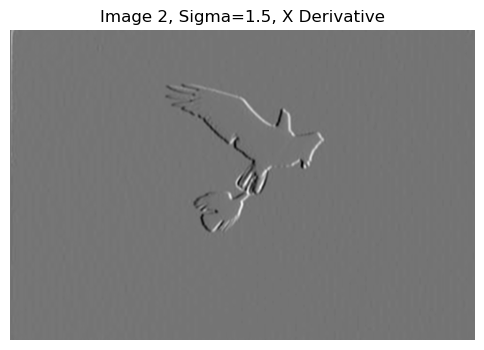

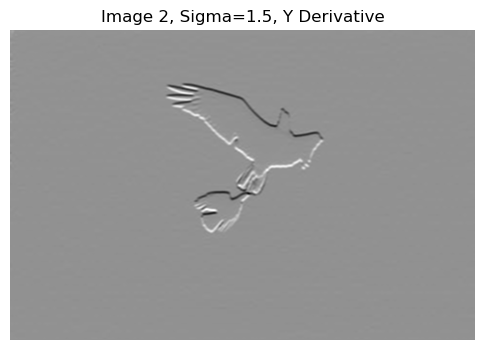

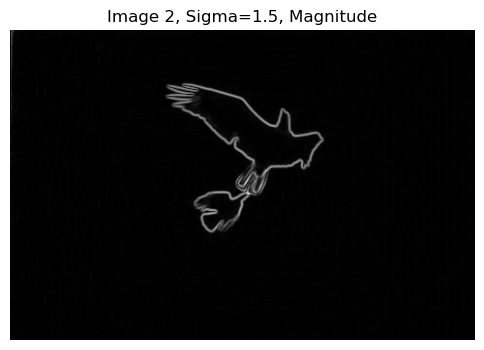

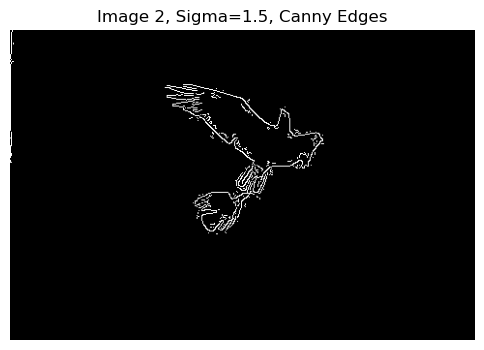

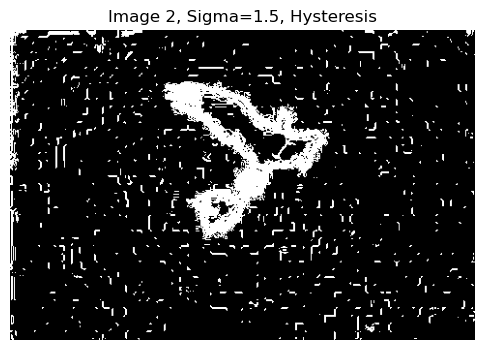

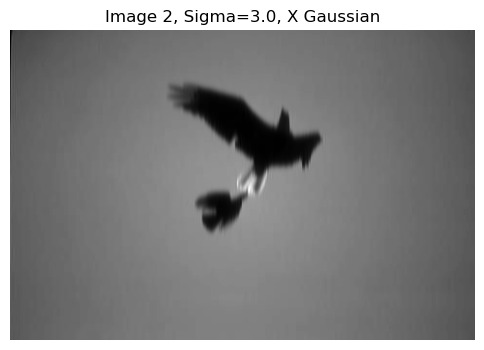

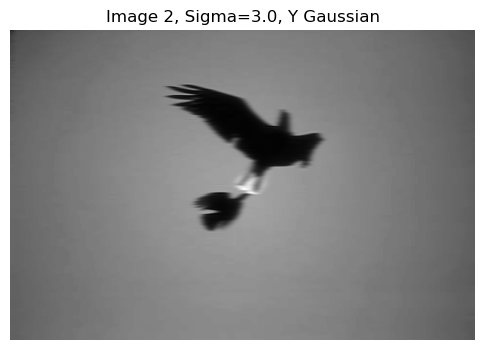

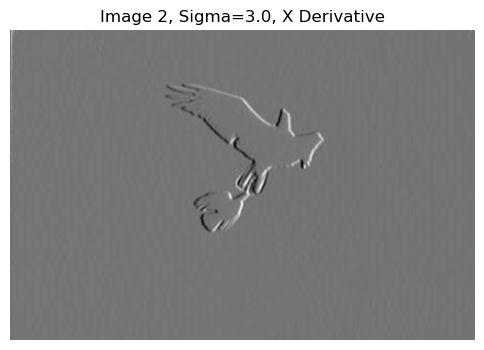

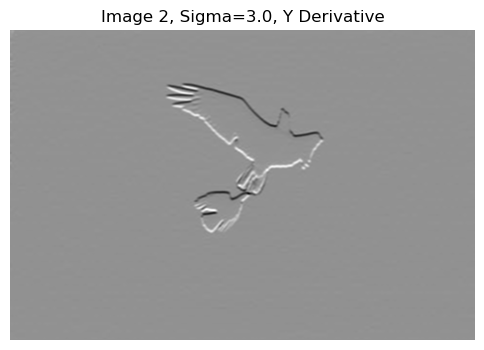

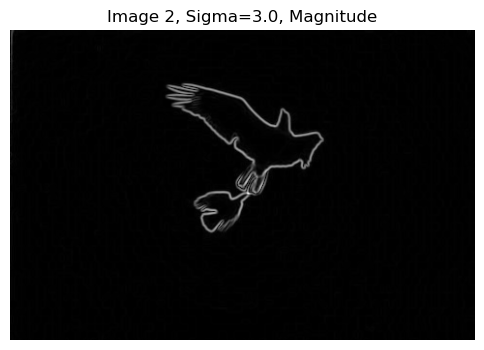

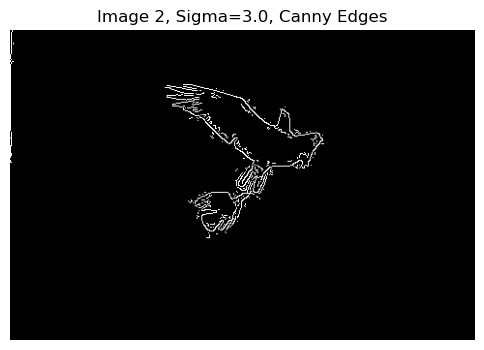

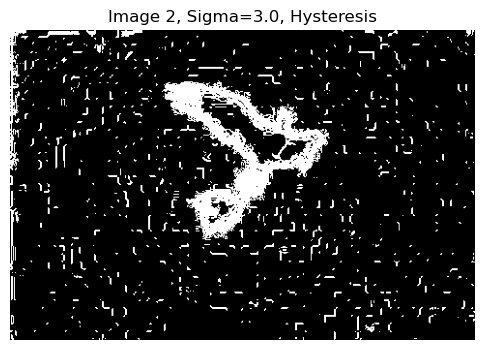

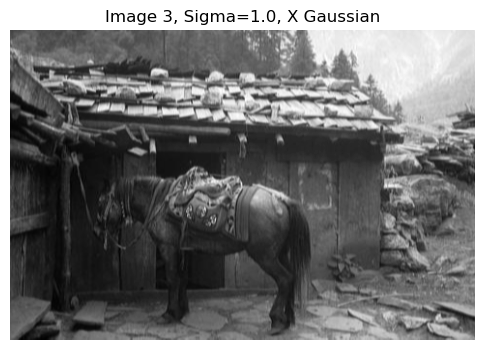

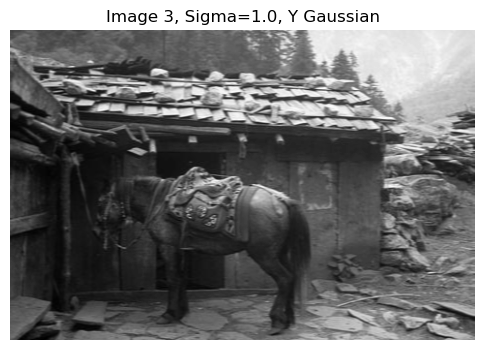

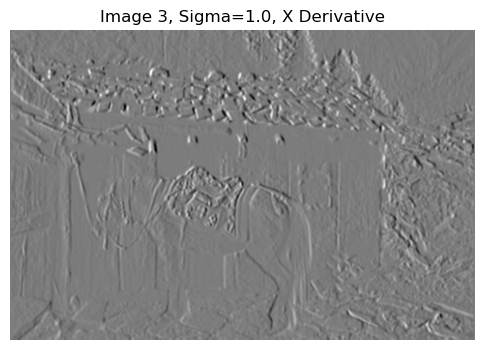

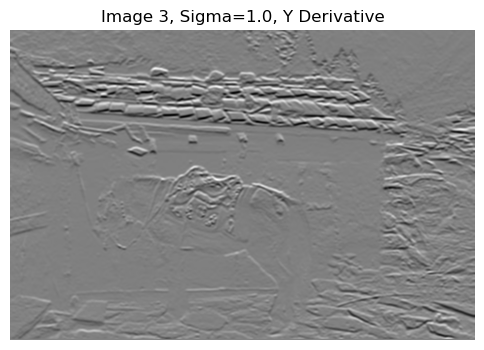

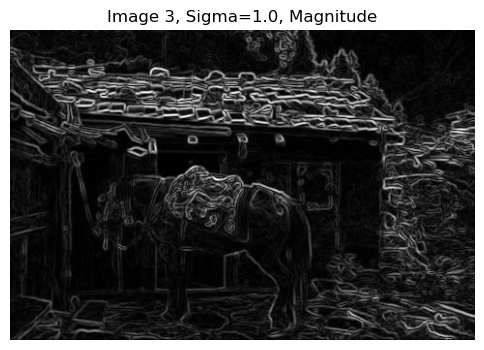

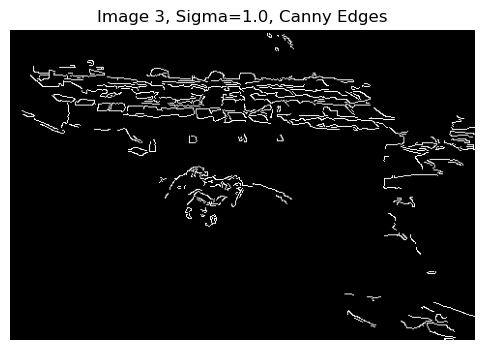

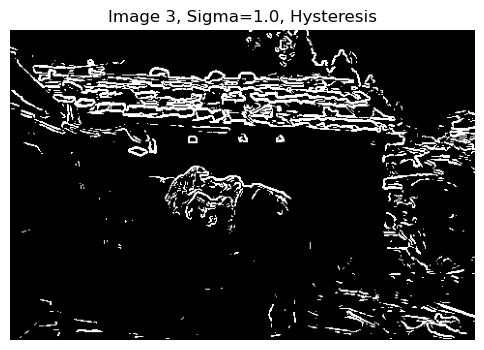

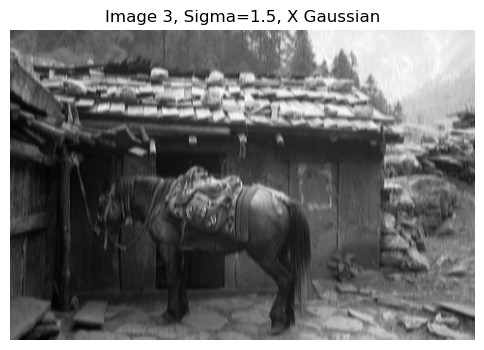

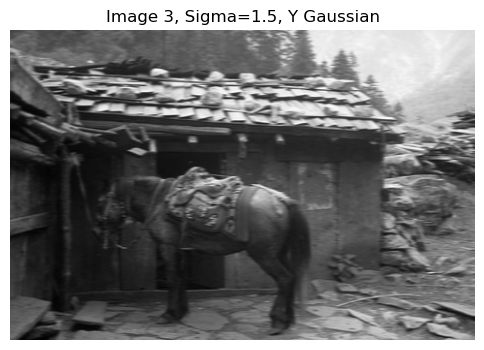

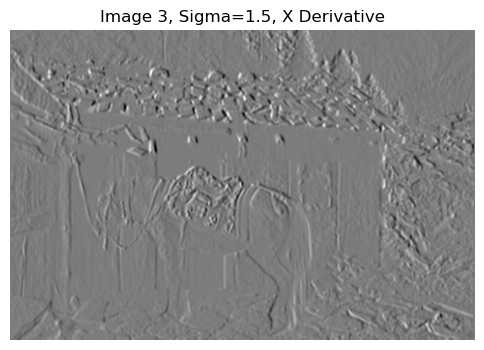

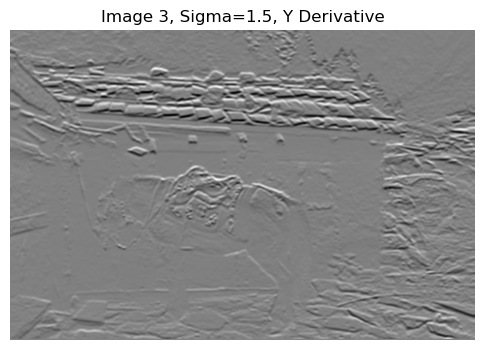

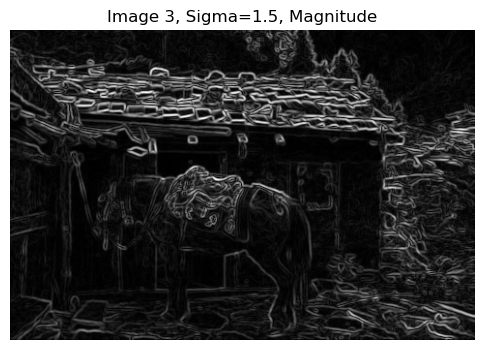

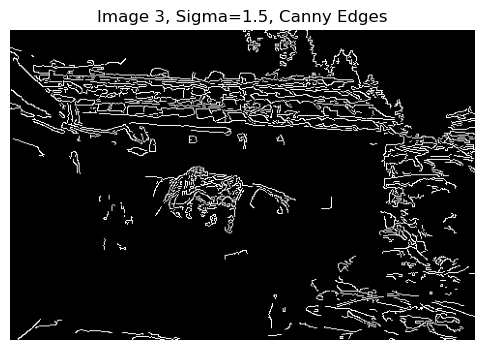

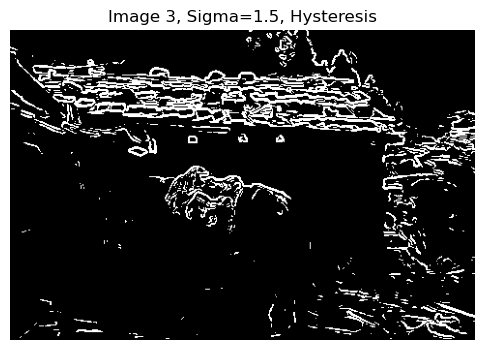

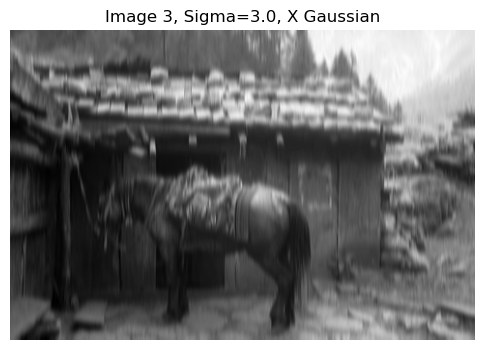

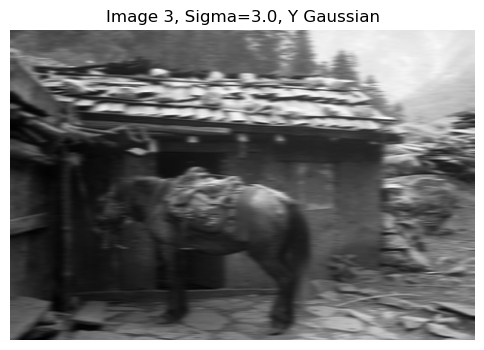

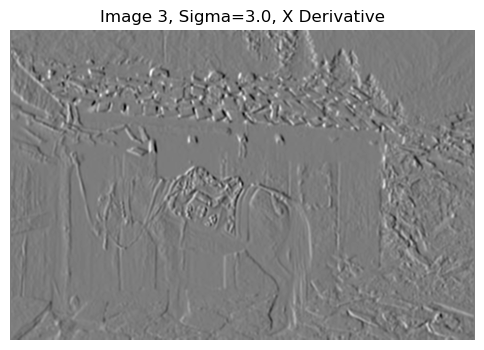

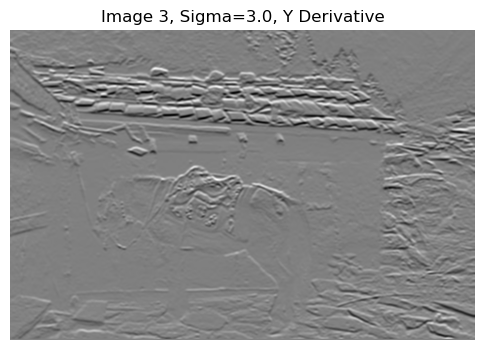

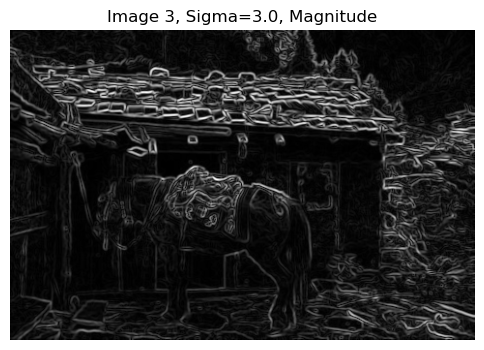

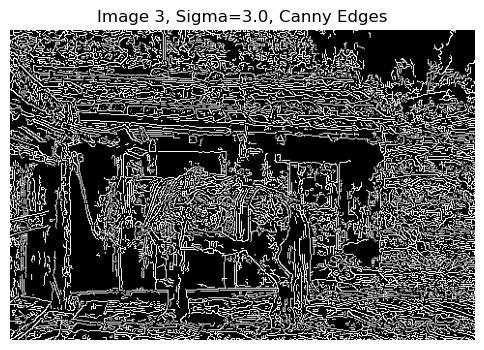

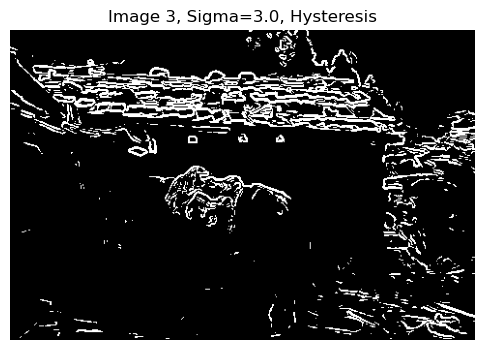

In [8]:
# Displaying separate images for each sigma value and for each process

for idx, img_path in enumerate(I):
    image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    
    for s_idx, sigma in enumerate(sigma_values):
        results = process_image_for_display(image, sigma)
        
        for r_idx, result in enumerate(results):
            plt.figure(figsize=(6, 6))
            plt.imshow(result, cmap='gray')
            
            # Title for the figure
            titles = ['X Gaussian', 'Y Gaussian', 'X Derivative', 'Y Derivative', 'Magnitude', 'Canny Edges', 'Hysteresis']
            plt.title(f'Image {idx+1}, Sigma={sigma}, {titles[r_idx]}')
            plt.axis('off')
            plt.show()
